📊 기술통계 분석 시작

① 구간별 평균 증가율(QoQ)


,M2_QoQ,LOAN_QoQ,IPI_QoQ
period,,,
전기,0.018156,0.018259,0.007147
후기,0.017386,0.019906,0.005036



② 구간별 괴리(GAP) 평균


,GAP_M2_IPI_QoQ,GAP_LOAN_IPI_QoQ
period,,
전기,0.011009,0.011112
후기,0.012350,0.014870



③ 구간별 상관계수(QoQ)


M2_QoQ  LOAN_QoQ   IPI_QoQ
period                                       
전기     M2_QoQ    1.000000  0.158575 -0.346297
       LOAN_QoQ  0.158575  1.000000  0.080537
       IPI_QoQ  -0.346297  0.080537  1.000000
후기     M2_QoQ    1.000000  0.618925 -0.110622
       LOAN_QoQ  0.618925  1.000000 -0.401562
       IPI_QoQ  -0.110622 -0.401562  1.000000


④ 구간별 변동성(표준편차)


,M2_QoQ,LOAN_QoQ,IPI_QoQ
period,,,
전기,0.007889,0.017271,0.012720
후기,0.010393,0.009448,0.013491



📈 시각화 생성


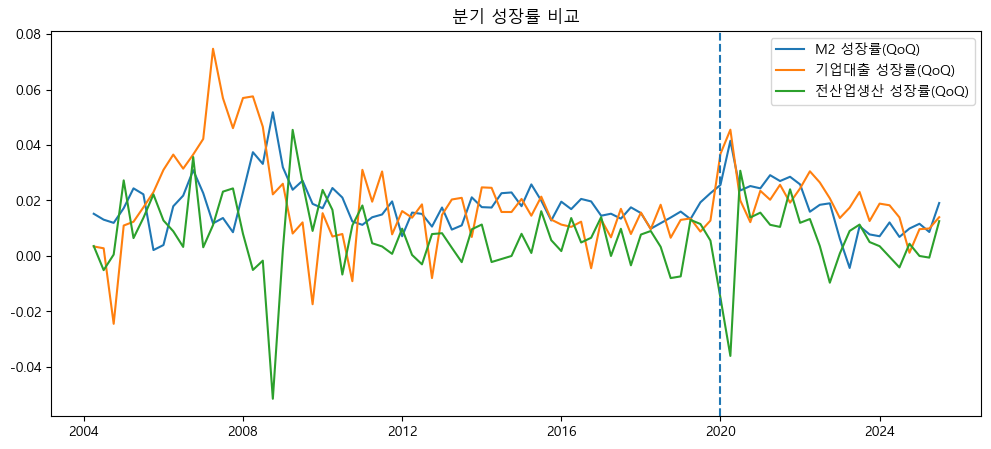

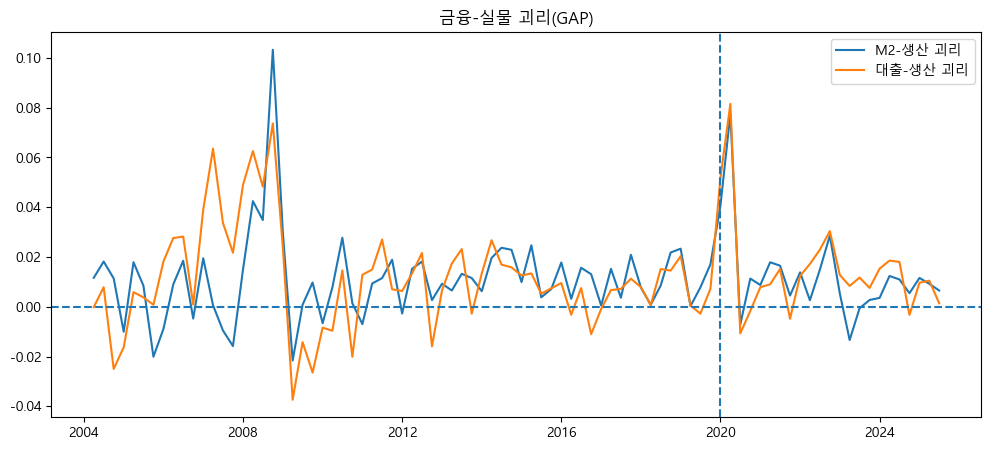

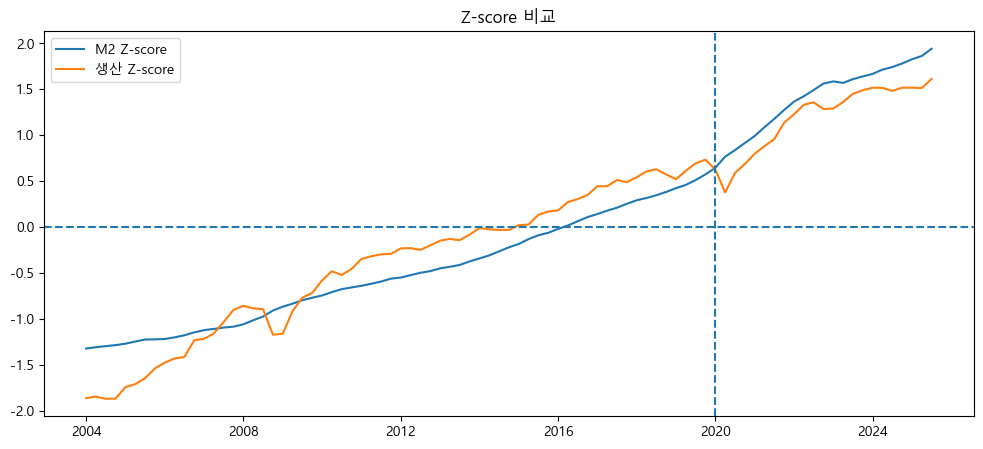


✅ 기술통계 분석 완료


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Malgun Gothic'   
mpl.rcParams['axes.unicode_minus'] = False      

# ============================================================
# 0) 경로
# ============================================================
PATH_M2   = "../data/전처리_M2.csv"
PATH_LOAN = "../data/전처리_기업대출.csv"
PATH_IPI  = "../data/전처리_전산업생산지수.csv"

# ============================================================
# 1) 유틸 함수
# ============================================================
def pick_first_existing_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError("date 컬럼을 찾을 수 없습니다.")

def to_datetime_series(s):
    s = s.astype(str).str.strip()
    s2 = s.str.replace(".", "-", regex=False).str.replace("/", "-", regex=False)

    mask_yyyymm = s2.str.fullmatch(r"\d{6}")
    s2.loc[mask_yyyymm] = (
        s2.loc[mask_yyyymm].str.slice(0,4) + "-" +
        s2.loc[mask_yyyymm].str.slice(4,6) + "-01"
    )

    mask_yyyymm2 = s2.str.fullmatch(r"\d{4}-\d{2}")
    s2.loc[mask_yyyymm2] = s2.loc[mask_yyyymm2] + "-01"

    return pd.to_datetime(s2, errors="coerce")

def load_series_csv(path, value_name):
    df = pd.read_csv(path)
    date_col = pick_first_existing_col(df, ["date","Date","기간","시점","time"])
    df = df.rename(columns={date_col: "date"})

    value_candidates = [c for c in df.columns if c != "date"]
    val_col = value_candidates[0]

    out = df[["date", val_col]].copy()
    out["date"] = to_datetime_series(out["date"])
    out[val_col] = pd.to_numeric(out[val_col], errors="coerce")
    out = out.dropna().sort_values("date").reset_index(drop=True)
    return out.rename(columns={val_col: value_name})

def to_quarter_mean(df, col):
    tmp = df.copy()
    tmp["quarter"] = tmp["date"].dt.to_period("Q")
    tmp = tmp.groupby("quarter", as_index=False)[col].mean()
    tmp["date"] = tmp["quarter"].dt.to_timestamp(how="start")
    return tmp[["date", col]]

def add_growth_features(df, col):
    out = df.copy()
    out[f"{col}_QoQ"] = np.log(out[col]).diff()
    out[f"{col}_YoY"] = np.log(out[col]).diff(4)
    out[f"{col}_Z"]   = (out[col] - out[col].mean()) / out[col].std()
    return out

# ============================================================
# 2) 데이터 불러오기
# ============================================================
m2   = load_series_csv(PATH_M2, "M2")
loan = load_series_csv(PATH_LOAN, "LOAN")
ipi  = load_series_csv(PATH_IPI, "IPI")

# 분기 통일
m2_q   = to_quarter_mean(m2, "M2")
loan_q = to_quarter_mean(loan, "LOAN")
ipi_q  = to_quarter_mean(ipi, "IPI")

df = (m2_q.merge(loan_q, on="date")
            .merge(ipi_q, on="date")
            .sort_values("date")
            .reset_index(drop=True))

# 성장률 및 Z-score
df = add_growth_features(df, "M2")
df = add_growth_features(df, "LOAN")
df = add_growth_features(df, "IPI")

# 괴리 지표
df["GAP_M2_IPI_QoQ"]   = df["M2_QoQ"] - df["IPI_QoQ"]
df["GAP_LOAN_IPI_QoQ"] = df["LOAN_QoQ"] - df["IPI_QoQ"]

# 전기/후기 구분
split_date = pd.to_datetime("2020-01-01")
df["period"] = np.where(df["date"] < split_date, "전기", "후기")

print("📊 기술통계 분석 시작")

# ============================================================
# 3) 기술통계 표 출력
# ============================================================

print("\n① 구간별 평균 증가율(QoQ)")
display(df.groupby("period")[["M2_QoQ","LOAN_QoQ","IPI_QoQ"]].mean())

print("\n② 구간별 괴리(GAP) 평균")
display(df.groupby("period")[["GAP_M2_IPI_QoQ","GAP_LOAN_IPI_QoQ"]].mean())

print("\n③ 구간별 상관계수(QoQ)")
display(df.groupby("period")[["M2_QoQ","LOAN_QoQ","IPI_QoQ"]].corr())

print("\n④ 구간별 변동성(표준편차)")
display(df.groupby("period")[["M2_QoQ","LOAN_QoQ","IPI_QoQ"]].std())

# ============================================================
# 4) 시각화
# ============================================================

print("\n📈 시각화 생성")

# 성장률 비교
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["M2_QoQ"], label="M2 성장률(QoQ)")
plt.plot(df["date"], df["LOAN_QoQ"], label="기업대출 성장률(QoQ)")
plt.plot(df["date"], df["IPI_QoQ"], label="전산업생산 성장률(QoQ)")
plt.axvline(split_date, linestyle="--")
plt.legend()
plt.title("분기 성장률 비교")
plt.show()

# 괴리
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["GAP_M2_IPI_QoQ"], label="M2-생산 괴리")
plt.plot(df["date"], df["GAP_LOAN_IPI_QoQ"], label="대출-생산 괴리")
plt.axhline(0, linestyle="--")
plt.axvline(split_date, linestyle="--")
plt.legend()
plt.title("금융-실물 괴리(GAP)")
plt.show()

# Z-score 비교
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["M2_Z"], label="M2 Z-score")
plt.plot(df["date"], df["IPI_Z"], label="생산 Z-score")
plt.axhline(0, linestyle="--")
plt.axvline(split_date, linestyle="--")
plt.legend()
plt.title("Z-score 비교")
plt.show()

print("\n✅ 기술통계 분석 완료")

가설1 이벤트 분석 시작

[전체 시계열 점검 그래프]


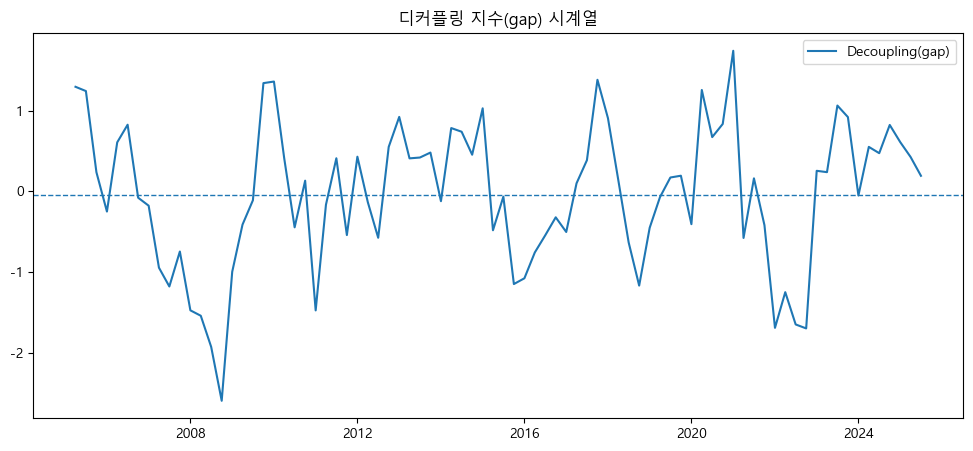

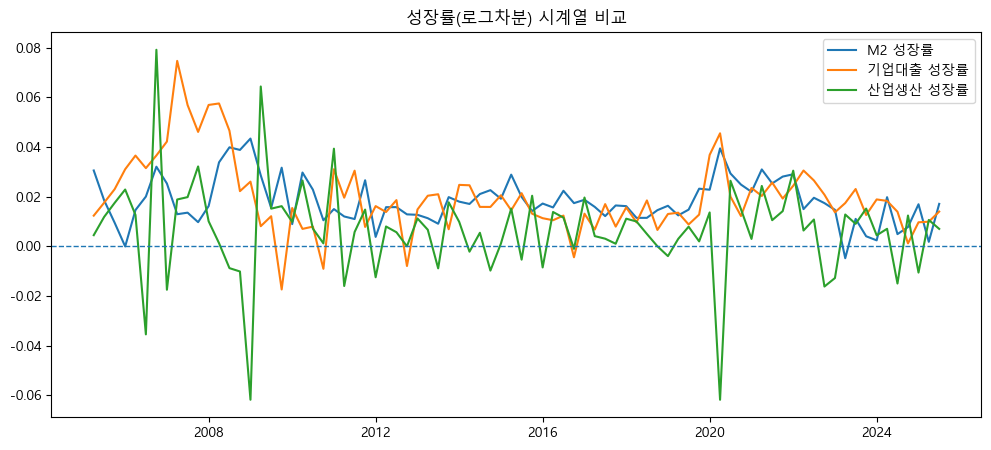

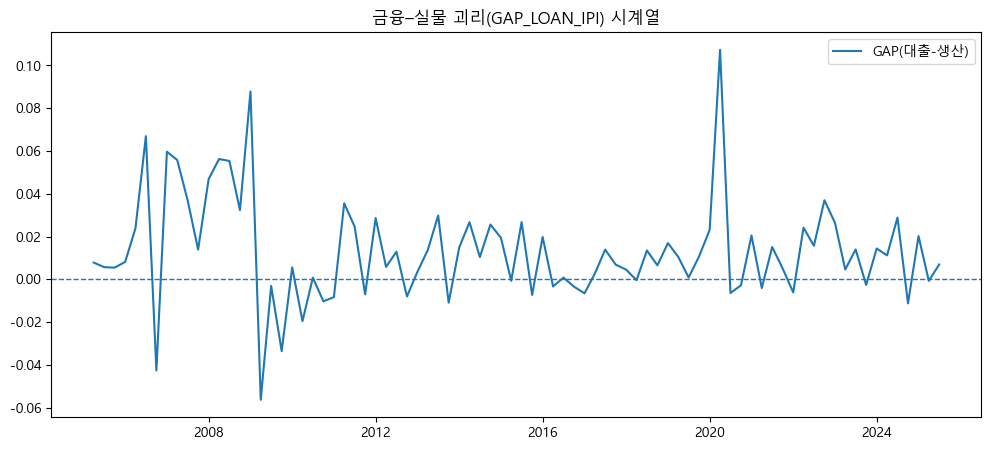


이벤트 기준값: 1.0191
이벤트 개수(월 관측치): 9

이벤트 시작 시점:
2005-04-01
2009-10-01
2015-01-01
2017-10-01
2020-04-01
2021-01-01
2023-07-01

[디커플링 이벤트 표시 그래프]


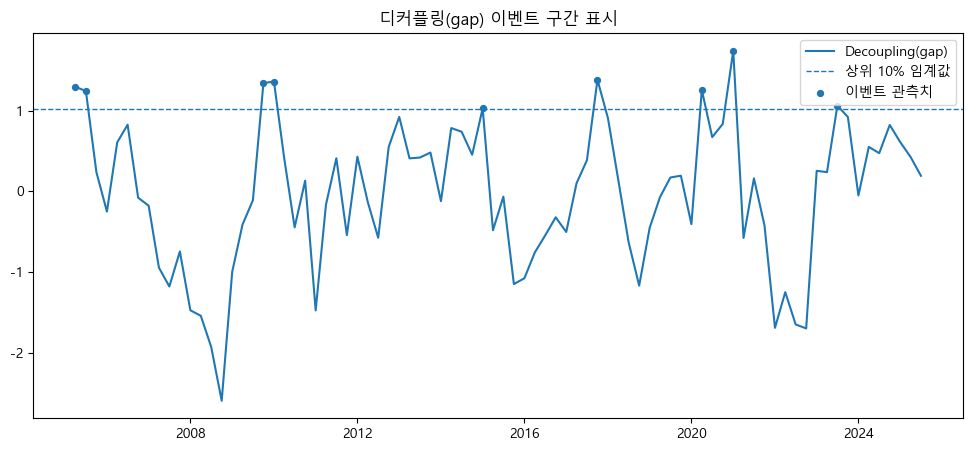


 이벤트: 2005-04-01


,구간,M2_QoQ,LOAN_QoQ,IPI_QoQ,GAP_LOAN_IPI
0,사전,NaN,NaN,NaN,NaN
1,이벤트,0.014608,0.020982,0.014165,0.006817
2,사후,0.022985,0.036695,0.009697,0.026998



 이벤트: 2009-10-01


,구간,M2_QoQ,LOAN_QoQ,IPI_QoQ,GAP_LOAN_IPI
0,사전,0.031559,0.017111,0.001887,0.015224
1,이벤트,0.023272,0.003237,0.014898,-0.011661
2,사후,0.012109,0.017998,0.007559,0.010440



 이벤트: 2015-01-01


,구간,M2_QoQ,LOAN_QoQ,IPI_QoQ,GAP_LOAN_IPI
0,사전,0.019669,0.020251,0.000822,0.019429
1,이벤트,0.020517,0.017390,0.007809,0.009581
2,사후,0.018147,0.007436,0.003945,0.003490



 이벤트: 2017-10-01


,구간,M2_QoQ,LOAN_QoQ,IPI_QoQ,GAP_LOAN_IPI
0,사전,0.016031,0.008102,0.006434,0.001669
1,이벤트,0.013875,0.012917,0.006767,0.006150
2,사후,0.014518,0.010472,0.001725,0.008747



 이벤트: 2020-04-01


,구간,M2_QoQ,LOAN_QoQ,IPI_QoQ,GAP_LOAN_IPI
0,사전,0.018297,0.017969,0.006615,0.011355
1,이벤트,0.028882,0.025301,-0.004390,0.029692
2,사후,0.028340,0.022379,0.019859,0.002520



 이벤트: 2021-01-01


,구간,M2_QoQ,LOAN_QoQ,IPI_QoQ,GAP_LOAN_IPI
0,사전,0.029095,0.028631,-0.001722,0.030352
1,이벤트,0.026571,0.022160,0.012984,0.009176
2,사후,0.020226,0.025541,0.007842,0.017699



 이벤트: 2023-07-01


,구간,M2_QoQ,LOAN_QoQ,IPI_QoQ,GAP_LOAN_IPI
0,사전,0.011701,0.019595,-0.001359,0.020953
1,이벤트,0.009306,0.018204,0.008922,0.009283
2,사후,0.007837,0.008657,-0.000658,0.009316



[이벤트별 GAP(대출-생산) 사전/이벤트/사후 비교]


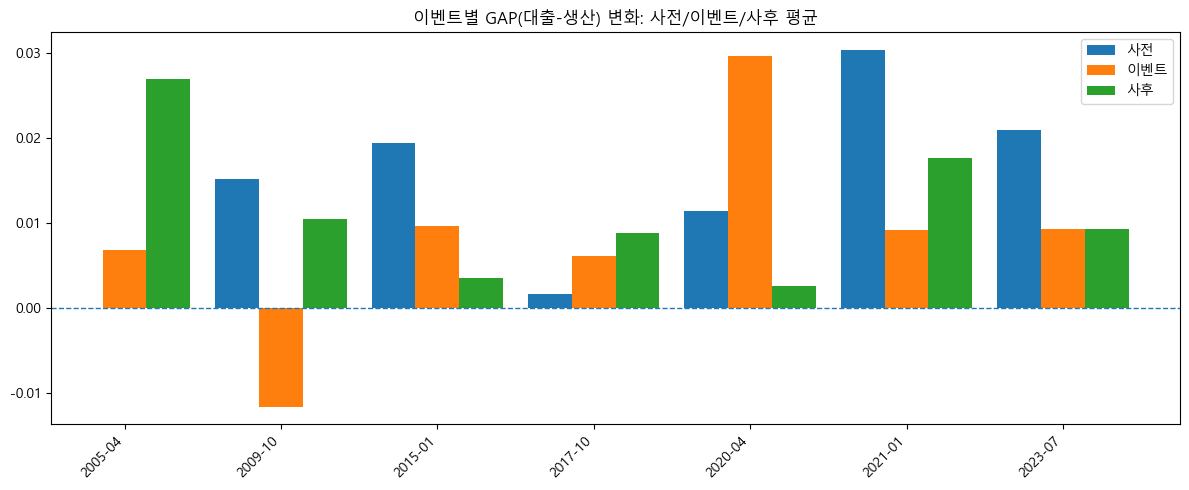


이벤트 오버레이 그래프(평균 경로)


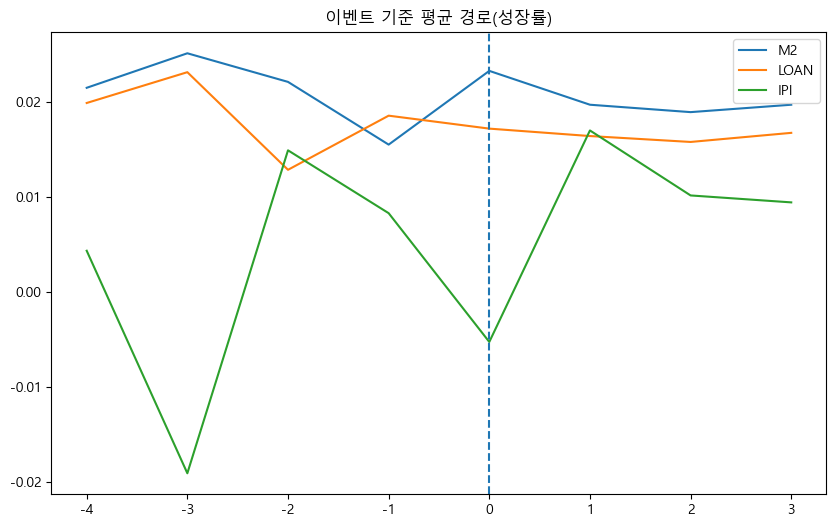

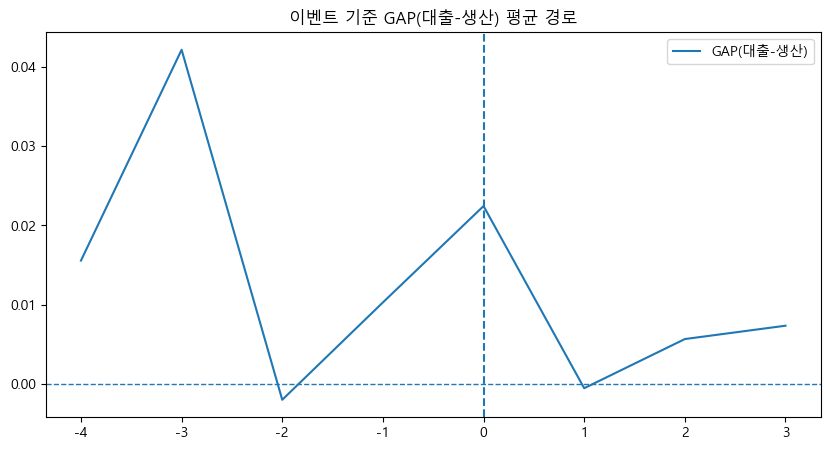


[이벤트 vs 비이벤트 GAP 분포 비교]


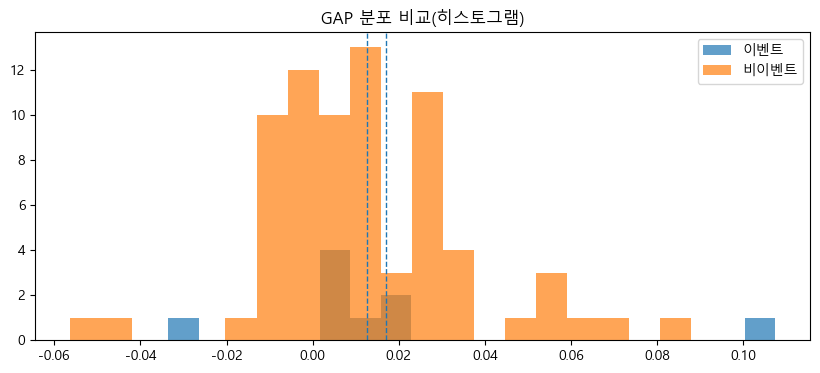

C:\Users\김가은\AppData\Local\Temp\ipykernel_10276\3783819417.py:259: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([nonevent_gap.dropna(), event_gap.dropna()], labels=["비이벤트", "이벤트"])


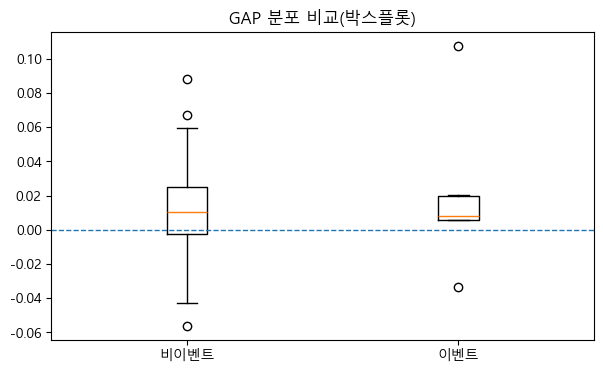


비모수 검정 결과 (Mann-Whitney U)
U-stat: 348.0
p-value: 0.7781

이벤트 기반 분석 완료 ✅


In [9]:
# ============================================================
# 가설 1 <이벤트 기반> 금융전달경로 단절 분석 (시각화 강화 + rolling 제외)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

print("가설1 이벤트 분석 시작")

# ============================================================
# 1. 데이터 로드
# ============================================================

PATH_M2   = "../data/전처리_M2.csv"
PATH_LOAN = "../data/전처리_기업대출.csv"
PATH_IPI  = "../data/전처리_전산업생산지수.csv"
PATH_DECOUPLING = "../../윤성/data/decoupling.csv"

def load_series(path, value_name):
    df = pd.read_csv(path)
    date_col = [c for c in df.columns if "date" in c.lower() or "기간" in c or "시점" in c][0]
    val_col  = [c for c in df.columns if c != date_col][0]
    df = df.rename(columns={date_col: "date", val_col: value_name})
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df[value_name] = pd.to_numeric(df[value_name], errors="coerce")
    df = df.dropna(subset=["date", value_name]).sort_values("date").reset_index(drop=True)
    return df[["date", value_name]]

m2   = load_series(PATH_M2, "M2")
loan = load_series(PATH_LOAN, "LOAN")
ipi  = load_series(PATH_IPI, "IPI")

dec = pd.read_csv(PATH_DECOUPLING)
dec.columns = dec.columns.str.strip()
dec["date"] = pd.to_datetime(dec["date"], errors="coerce")
dec = dec.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

# ✅ 디커플링 정의: gap 우선, 없으면 fin-real로 생성
if "gap" not in dec.columns:
    if ("fin_index" in dec.columns) and ("real_index" in dec.columns):
        dec["gap"] = pd.to_numeric(dec["fin_index"], errors="coerce") - pd.to_numeric(dec["real_index"], errors="coerce")
    else:
        raise ValueError("decoupling 파일에서 'gap' 또는 ('fin_index','real_index')를 찾을 수 없습니다.")

dec["gap"] = pd.to_numeric(dec["gap"], errors="coerce")
dec = dec.dropna(subset=["gap"])
dec = dec.groupby("date", as_index=False)["gap"].mean()

# ============================================================
# 2. 월 기준 병합
# ============================================================

df = (dec.merge(m2, on="date", how="inner")
        .merge(loan, on="date", how="inner")
        .merge(ipi, on="date", how="inner")
        .sort_values("date")
        .reset_index(drop=True))

# 성장률 계산 (⚠️ 월 데이터에 log diff를 적용 / 변수명은 기존 유지)
df["M2_QoQ"]   = np.log(df["M2"]).diff()
df["LOAN_QoQ"] = np.log(df["LOAN"]).diff()
df["IPI_QoQ"]  = np.log(df["IPI"]).diff()

df["GAP_M2_IPI"]   = df["M2_QoQ"] - df["IPI_QoQ"]
df["GAP_LOAN_IPI"] = df["LOAN_QoQ"] - df["IPI_QoQ"]

df = df.dropna().reset_index(drop=True)

# ============================================================
# ✅ (추가 시각화 0) 전체 시계열 점검(디커플링/성장률/GAP)
# ============================================================

print("\n[전체 시계열 점검 그래프]")

plt.figure(figsize=(12,5))
plt.plot(df["date"], df["gap"], label="Decoupling(gap)")
plt.axhline(df["gap"].mean(), linestyle="--", linewidth=1)
plt.title("디커플링 지수(gap) 시계열")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(df["date"], df["M2_QoQ"], label="M2 성장률")
plt.plot(df["date"], df["LOAN_QoQ"], label="기업대출 성장률")
plt.plot(df["date"], df["IPI_QoQ"], label="산업생산 성장률")
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("성장률(로그차분) 시계열 비교")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(df["date"], df["GAP_LOAN_IPI"], label="GAP(대출-생산)")
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("금융–실물 괴리(GAP_LOAN_IPI) 시계열")
plt.legend()
plt.show()

# ============================================================
# 3. 이벤트 자동 추출 (상위 10%)
# ============================================================

threshold = df["gap"].quantile(0.9)
df["event_flag"] = (df["gap"] >= threshold).astype(int)

print("\n이벤트 기준값:", round(threshold, 4))
print("이벤트 개수(월 관측치):", int(df["event_flag"].sum()))

# 이벤트 시작점 추출(연속 구간의 시작)
event_starts = df.loc[(df["event_flag"]==1) & (df["event_flag"].shift(1)!=1), "date"].tolist()

print("\n이벤트 시작 시점:")
for d in event_starts:
    print(d.date())

# ============================================================
# ✅ (추가 시각화 1) 디커플링 + 이벤트 마킹(핵심)
# ============================================================

print("\n[디커플링 이벤트 표시 그래프]")

plt.figure(figsize=(12,5))
plt.plot(df["date"], df["gap"], label="Decoupling(gap)")
plt.axhline(threshold, linestyle="--", linewidth=1, label="상위 10% 임계값")
plt.scatter(df.loc[df["event_flag"]==1, "date"], df.loc[df["event_flag"]==1, "gap"], s=18, label="이벤트 관측치")
plt.title("디커플링(gap) 이벤트 구간 표시")
plt.legend()
plt.show()

# ============================================================
# 4. 전/중/후 평균 테이블 생성
# ============================================================

window_pre  = 4
window_post = 4

summary_tables = []

for start in event_starts:
    idx = df.index[df["date"] == start][0]

    pre  = df.iloc[max(0, idx-window_pre):idx]
    mid  = df.iloc[idx:idx+window_post]
    post = df.iloc[idx+window_post:idx+window_post*2]

    table = pd.DataFrame({
        "구간": ["사전", "이벤트", "사후"],
        "M2_QoQ": [pre["M2_QoQ"].mean(), mid["M2_QoQ"].mean(), post["M2_QoQ"].mean()],
        "LOAN_QoQ": [pre["LOAN_QoQ"].mean(), mid["LOAN_QoQ"].mean(), post["LOAN_QoQ"].mean()],
        "IPI_QoQ": [pre["IPI_QoQ"].mean(), mid["IPI_QoQ"].mean(), post["IPI_QoQ"].mean()],
        "GAP_LOAN_IPI": [pre["GAP_LOAN_IPI"].mean(), mid["GAP_LOAN_IPI"].mean(), post["GAP_LOAN_IPI"].mean()]
    })

    print("\n 이벤트:", start.date())
    display(table)
    summary_tables.append(table)

# ============================================================
# ✅ (추가 시각화 2) 이벤트별 GAP 변화(사전/이벤트/사후) 막대그래프
# ============================================================

print("\n[이벤트별 GAP(대출-생산) 사전/이벤트/사후 비교]")

event_labels = []
pre_list, mid_list, post_list = [], [], []

for start in event_starts:
    idx = df.index[df["date"] == start][0]
    pre  = df.iloc[max(0, idx-window_pre):idx]
    mid  = df.iloc[idx:idx+window_post]
    post = df.iloc[idx+window_post:idx+window_post*2]

    event_labels.append(start.strftime("%Y-%m"))
    pre_list.append(pre["GAP_LOAN_IPI"].mean())
    mid_list.append(mid["GAP_LOAN_IPI"].mean())
    post_list.append(post["GAP_LOAN_IPI"].mean())

x = np.arange(len(event_labels))
w = 0.28

plt.figure(figsize=(12,5))
plt.bar(x - w, pre_list, width=w, label="사전")
plt.bar(x,     mid_list, width=w, label="이벤트")
plt.bar(x + w, post_list, width=w, label="사후")
plt.axhline(0, linestyle="--", linewidth=1)
plt.xticks(x, event_labels, rotation=45, ha="right")
plt.title("이벤트별 GAP(대출-생산) 변화: 사전/이벤트/사후 평균")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 5. 이벤트 오버레이 그래프 (평균 경로)
# ============================================================

print("\n이벤트 오버레이 그래프(평균 경로)")

overlay = []

# t = -4,-3,-2,-1,0,1,2,3 (총 8)
for start in event_starts:
    idx = df.index[df["date"] == start][0]
    window = df.iloc[max(0, idx-window_pre): idx+window_post].copy()

    if len(window) != (window_pre + window_post):
        continue

    window["t"] = list(range(-window_pre, 0)) + list(range(0, window_post))
    overlay.append(window[["t", "M2_QoQ", "LOAN_QoQ", "IPI_QoQ", "GAP_LOAN_IPI"]])

overlay_df = pd.concat(overlay, ignore_index=True)
mean_path = overlay_df.groupby("t").mean()

plt.figure(figsize=(10,6))
plt.plot(mean_path.index, mean_path["M2_QoQ"], label="M2")
plt.plot(mean_path.index, mean_path["LOAN_QoQ"], label="LOAN")
plt.plot(mean_path.index, mean_path["IPI_QoQ"], label="IPI")
plt.axvline(0, linestyle="--")
plt.legend()
plt.title("이벤트 기준 평균 경로(성장률)")
plt.show()

# ============================================================
# ✅ (추가 시각화 3) 오버레이: GAP(대출-생산) 평균 경로
# ============================================================

plt.figure(figsize=(10,5))
plt.plot(mean_path.index, mean_path["GAP_LOAN_IPI"], label="GAP(대출-생산)")
plt.axvline(0, linestyle="--")
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("이벤트 기준 GAP(대출-생산) 평균 경로")
plt.legend()
plt.show()

# ============================================================
# ✅ (추가 시각화 4) 이벤트 vs 비이벤트 GAP 분포 비교(히스토그램/박스플롯)
# ============================================================

print("\n[이벤트 vs 비이벤트 GAP 분포 비교]")

event_gap = df.loc[df["event_flag"] == 1, "GAP_LOAN_IPI"]
nonevent_gap = df.loc[df["event_flag"] == 0, "GAP_LOAN_IPI"]

plt.figure(figsize=(10,4))
plt.hist(event_gap, bins=20, alpha=0.7, label="이벤트")
plt.hist(nonevent_gap, bins=20, alpha=0.7, label="비이벤트")
plt.axvline(event_gap.mean(), linestyle="--", linewidth=1)
plt.axvline(nonevent_gap.mean(), linestyle="--", linewidth=1)
plt.title("GAP 분포 비교(히스토그램)")
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.boxplot([nonevent_gap.dropna(), event_gap.dropna()], labels=["비이벤트", "이벤트"])
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("GAP 분포 비교(박스플롯)")
plt.show()

# ============================================================
# 6. 비모수 검정 (이벤트 vs 비이벤트)
# ============================================================

u_stat, p_val = stats.mannwhitneyu(event_gap.dropna(), nonevent_gap.dropna(), alternative="two-sided")

print("\n비모수 검정 결과 (Mann-Whitney U)")
print("U-stat:", round(u_stat, 4))
print("p-value:", round(p_val, 4))

print("\n이벤트 기반 분석 완료 ✅")
